# py-art gridding options

In [1]:
import pyart
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os
from osgeo import osr, gdal
import shutil
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mticker

warnings.filterwarnings("ignore", category=DeprecationWarning) 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
dpath = '/gws/nopw/j04/ncas_radar_vol2/pestdar/india/raw_data/Delhi06/'
fname = 'DLI200627080229.RAW4VJV'
fpath = os.path.join(dpath, fname)
radar = pyart.io.read(fpath)

outpath = '/gws/nopw/j04/ncas_radar_vol1/eeslb/pestdar/testing/geotiffs'

## Radar PPI plot

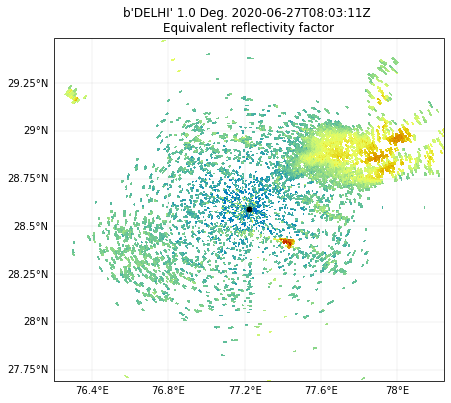

In [4]:
fig = plt.figure(figsize=[7, 7])

# set map projection
#projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],central_longitude=radar.longitude['data'][0])
projection=ccrs.PlateCarree()

## plot radar
display = pyart.graph.RadarMapDisplay(radar)
r = 100
min_lat  = radar.latitude['data'][0]  - (r / 6378 ) * (180 / np.pi)
max_lat  = radar.latitude['data'][0]  + (r / 6378 ) * (180 / np.pi)
min_lon = radar.longitude['data'][0] - (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)
max_lon = radar.longitude['data'][0] + (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)

ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
display.plot_ppi_map('reflectivity',1,ax=ax, vmin=-20, vmax=60, 
                     colorbar_flag = False, cmap = 'pyart_HomeyerRainbow', embelish = False, alpha = 1.0,
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     projection=projection,fig=fig, lat_0=radar.latitude['data'][0], lon_0=radar.longitude['data'][0])
ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
#ax1.set_title('Radar PPI', fontsize = 16)
xspace = 0.4
yspace = 0.25
lon_lines=np.arange(np.floor(min_lon), np.ceil(max_lon)+xspace, xspace)
lat_lines=np.arange(np.floor(min_lat), np.ceil(max_lat)+yspace, yspace)
gl = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, alpha = 0.7, zorder = 0.5, linewidth = 0.25)
gl.xlocator = mticker.FixedLocator(lon_lines)
gl.ylocator = mticker.FixedLocator(lat_lines)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Map to grid vs Map gates to grid

**Map to grid**: Field value for a grid point is found by interpolating from the collected points within a given radius of influence and weighting these nearby points according to their distance from the grid points  
**Map gates to grid**: For each radar gate that is not filtered a radius of influence is calculated. The weighted field values for that gate are added to all grid points within that radius. This routine scales linearly with the number of radar gates and the effective grid size.

_Comments:_ Map gates to grid is slower 

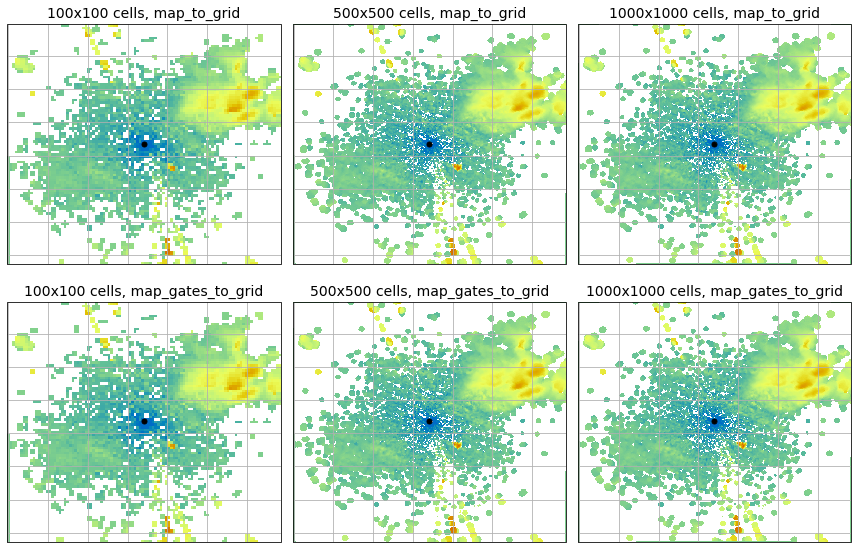

In [128]:
n_cells = [100,500,1000]
algos = ['map_to_grid', 'map_gates_to_grid']

for res in n_cells:
    for algo in algos:
        file = os.path.join(outpath,'out_{}_{}.tif'.format(str(res), algo))
        if not os.path.exists(file):
            #print('file doesnt exist')
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, res, res),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo=algo)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')

algos = ['map_to_grid', 'map_gates_to_grid']

fig, axs = plt.subplots(len(algos), len(n_cells), sharex=True, sharey=True, figsize=[12, 8], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, res in enumerate(n_cells):
    col_pos = count
    for count2, algo in enumerate(algos):
        row_pos = count2
        file = os.path.join(outpath,'out_{}_{}.tif'.format(str(res), algo))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}x{} cells, {}'.format(str(res), str(res), algo)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'none')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid vs Map Gates to Grid', fontsize = 20)
plt.tight_layout(pad = 1)

## Weighting function and map to grid/map gates to grid

**Weighting functions**: Barnes, Barnes2, Cressman, Nearest  


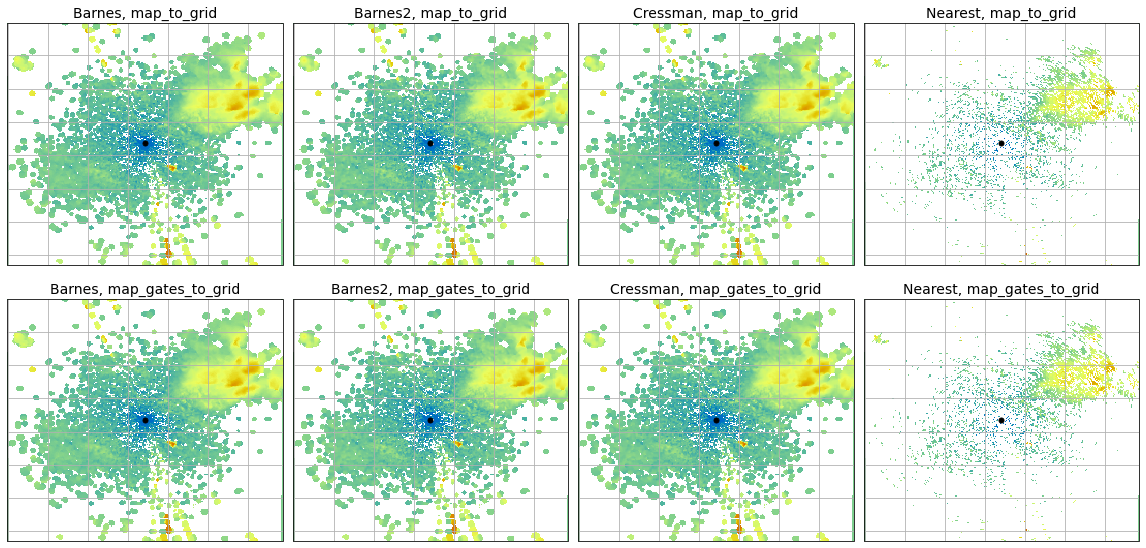

In [129]:
weight_fun = ['Barnes', 'Barnes2', 'Cressman', 'Nearest']
algos = ['map_to_grid', 'map_gates_to_grid']

for fun in weight_fun:
    for algo in algos:
        file = os.path.join(outpath,'out_{}_{}_z1000.tif'.format(fun, algo))
        if not os.path.exists(file):
            #print('file doesnt exist')
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 250, 250),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo=algo, weighting_function=fun)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')


fig, axs = plt.subplots(len(algos), len(weight_fun), sharex=True, sharey=True, figsize=[16, 8], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, fun in enumerate(weight_fun):
    col_pos = count
    for count2, algo in enumerate(algos):
        row_pos = count2
        file = os.path.join(outpath,'out_{}_{}_z1000.tif'.format(fun, algo))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}, {}'.format(fun, algo)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'none')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid vs Map Gates to Grid', fontsize = 20)
plt.tight_layout(pad = 1)

## Grid xy shape and weighting function 

**Grid shape**: Number of points in the grid (z, y, x)  

_Comments:_ Grid shape doesn't change much >250x250, using that for rest of testing

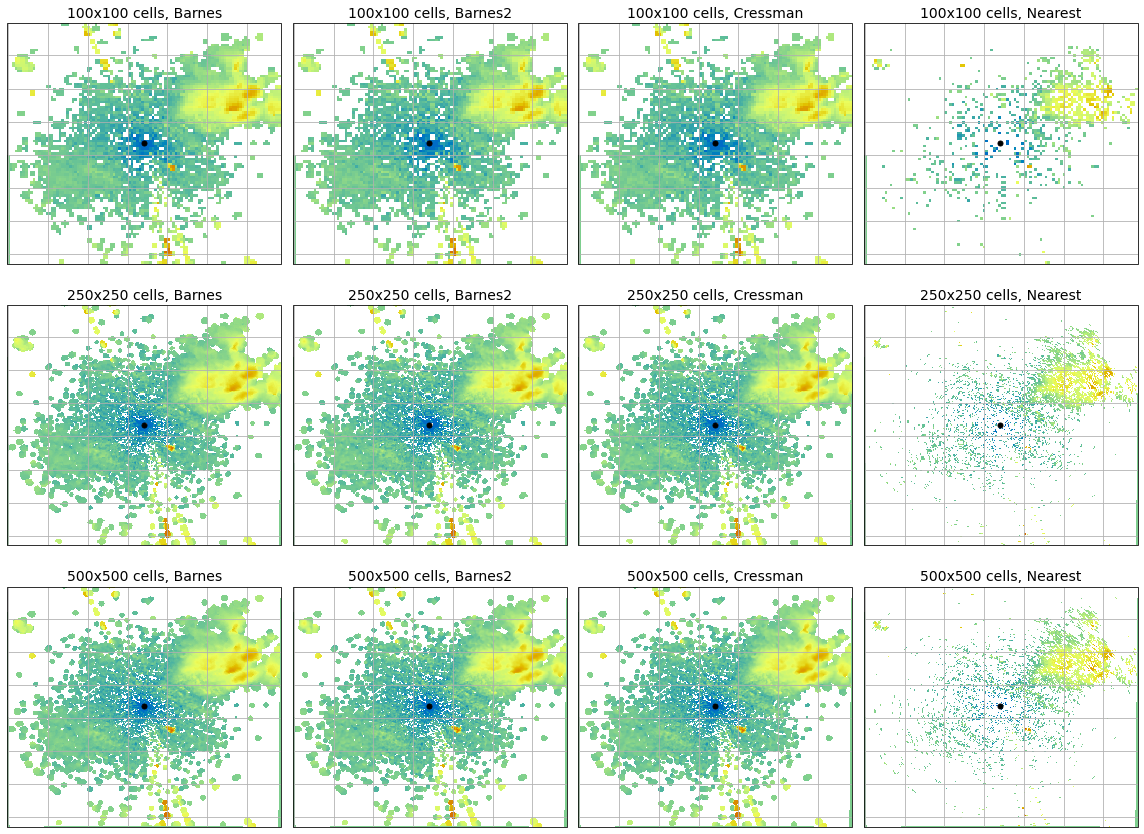

In [130]:
# create grid object from radar object
n_cells = [100, 250,500]
weight_fun = ['Barnes', 'Barnes2', 'Cressman', 'Nearest']

for res in n_cells:
    for fun in weight_fun:
        file = os.path.join(outpath,'out_{}_{}.tif'.format(str(res), fun))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, res, res),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function=fun)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')

#fig, axs = plt.subplots(len(weight_fun), len(n_cells), sharex=True, sharey=True, figsize=[12, 15], subplot_kw={'projection': ccrs.PlateCarree()})
fig, axs = plt.subplots(len(n_cells), len(weight_fun), sharex=True, sharey=True, figsize=[16, 12], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, res in enumerate(n_cells):
    row_pos = count
    for count2, fun in enumerate(weight_fun):
        col_pos = count2
        file = os.path.join(outpath,'out_{}_{}.tif'.format(str(res), fun))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}x{} cells, {}'.format(str(res), str(res), fun)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'none')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

## Grid z limits and weighting function

**Grid limits**: minimum and maximum grid location (inclusive) in meters for the z, y, x coordinates.

_Comments_: Using (1000,1000) z limit for rest of testing

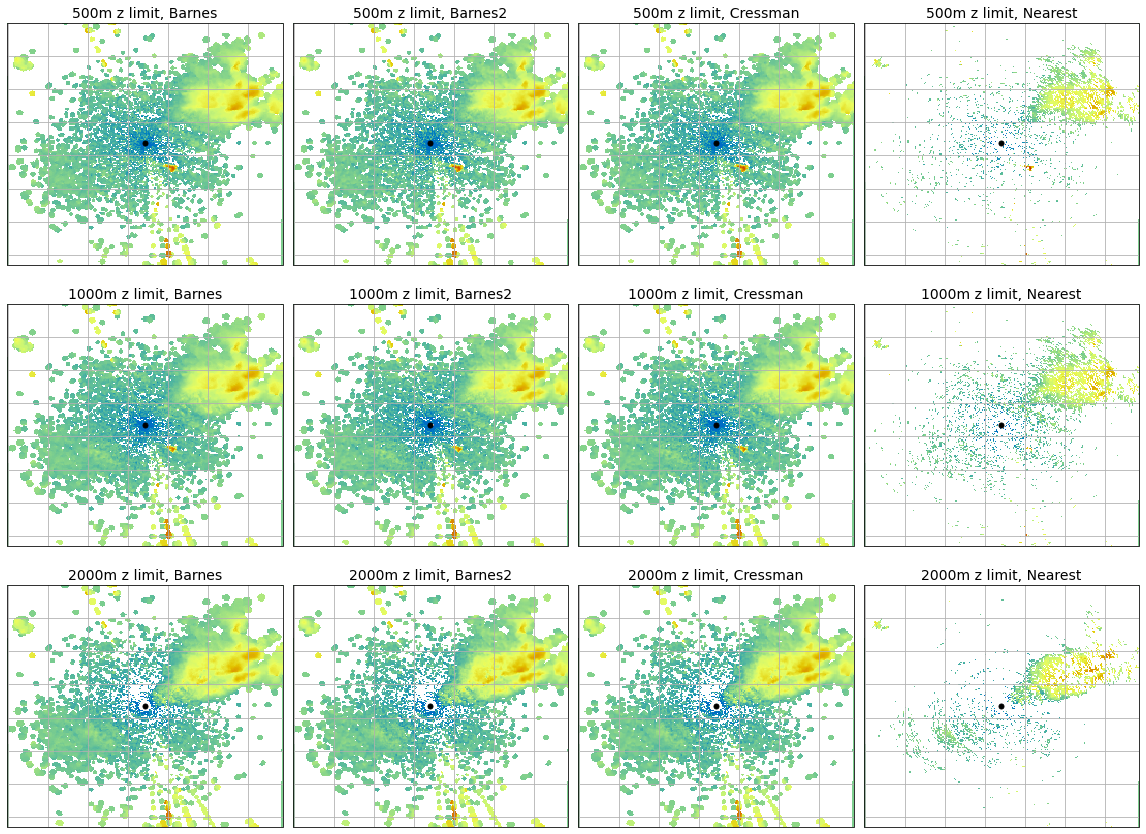

In [131]:
# create grid object from radar object
n_cells = [250]
weight_fun = ['Barnes', 'Barnes2', 'Cressman', 'Nearest']
z_lim = [500,1000, 2000]

for res in weight_fun:
    for z in z_lim:
        file = os.path.join(outpath,'out_{}_{}z.tif'.format(res, str(z)))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 250, 250),
                                          grid_limits=((z, z), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function=res)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')

#fig, axs = plt.subplots(len(weight_fun), len(n_cells), sharex=True, sharey=True, figsize=[12, 15], subplot_kw={'projection': ccrs.PlateCarree()})
fig, axs = plt.subplots(len(z_lim), len(weight_fun), sharex=True, sharey=True, figsize=[16, 12], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, res in enumerate(weight_fun):
    col_pos = count
    for count2, z in enumerate(z_lim):
        row_pos = count2
        file = os.path.join(outpath,'out_{}_{}z.tif'.format(res, str(z)))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}m z limit, {}'.format(z, res)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'none')
        #ax.pcolormesh(arr, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad =1)

## Radius of influence function 
A function which takes an z, y, x grid location, in meters, and returns a radius (in meters) within which all collected points will be included in the weighting for that grid point.

**constant**: constant radius of influence  
**dist**: radius grows with the distance from each radar  
**dist_beam**: radius grows with the distance from each radar and parameter are based on virtual beam sizes  

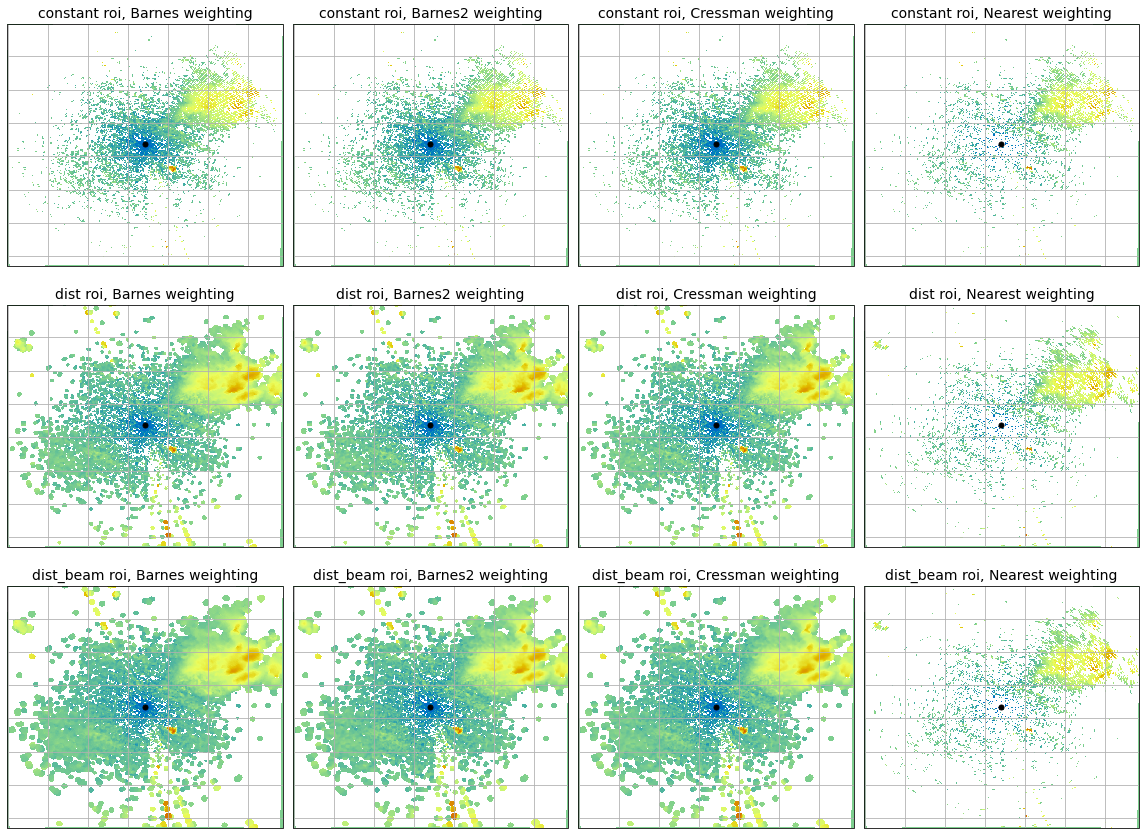

In [132]:
roi_fun = ['constant', 'dist', 'dist_beam']
weight_fun = ['Barnes', 'Barnes2', 'Cressman', 'Nearest']

for roi in roi_fun:
    for fun in weight_fun:
        file = os.path.join(outpath,'out_{}_{}_z1000.tif'.format(roi, fun))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 500, 500),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function=fun, roi_func = roi)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(roi_fun), len(weight_fun), sharex=True, sharey=True, figsize=[16, 12], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, roi in enumerate(roi_fun):
    row_pos = count
    for count2, fun in enumerate(weight_fun):
        col_pos = count2
        file = os.path.join(outpath,'out_{}_{}_z1000.tif'.format(roi, fun))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{} roi, {} weighting'.format(roi, fun)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'none')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

## constant roi function with different radius 
default = 500

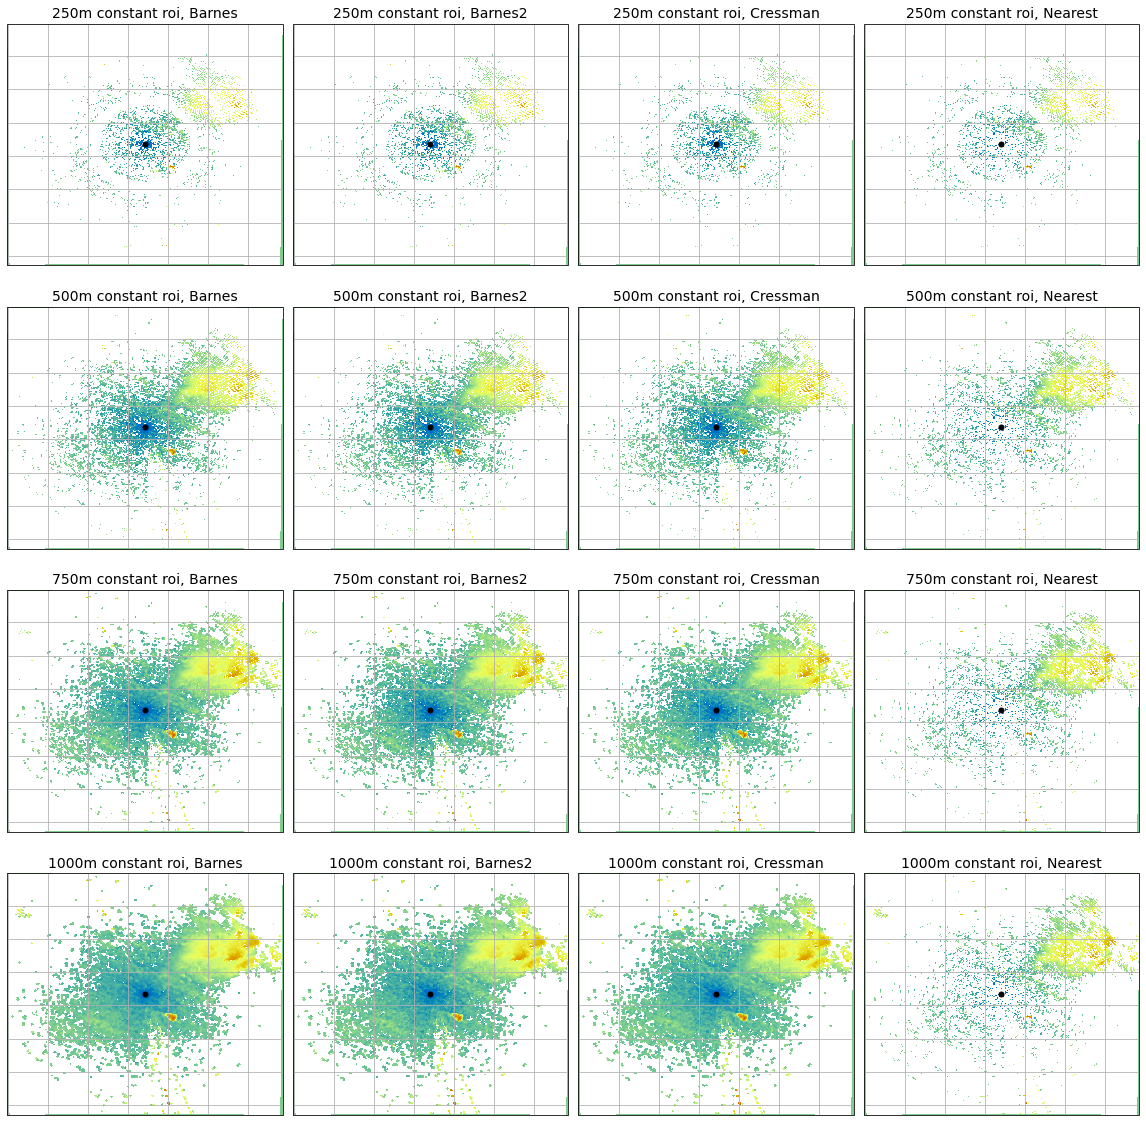

In [133]:
roi_fun = ['constant', 'dist', 'dist_beam']
weight_fun = ['Barnes', 'Barnes2', 'Cressman', 'Nearest']
roi_radius = [250, 500, 750, 1000]
for radius in roi_radius:
    for fun in weight_fun:
        file = os.path.join(outpath,'out_{}roi_{}_z1000.tif'.format(str(radius), fun))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 500, 500),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function=fun, roi_func = 'constant', constant_roi = radius)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(roi_radius), len(weight_fun), sharex=True, sharey=True, figsize=[16, 16], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, radius in enumerate(roi_radius):
    row_pos = count
    for count2, fun in enumerate(weight_fun):
        col_pos = count2
        file = os.path.join(outpath,'out_{}roi_{}_z1000.tif'.format(str(radius), fun))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}m constant roi, {}'.format(radius, fun)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

## dist roi function with different parameters

**z_factor**: radius size increase, in meters, per meter increase in the z-dimension from the nearest radar (default = 0.05)  
**xy_factor**: radius size increase, in meters, per meter increase in the xy-distance from the nearest radar (default = 0.02)  
**min_radius**: minimum radius of influence in meters (default = 500)

_Comments:_ Barnes weighting

### radius and xy_factor

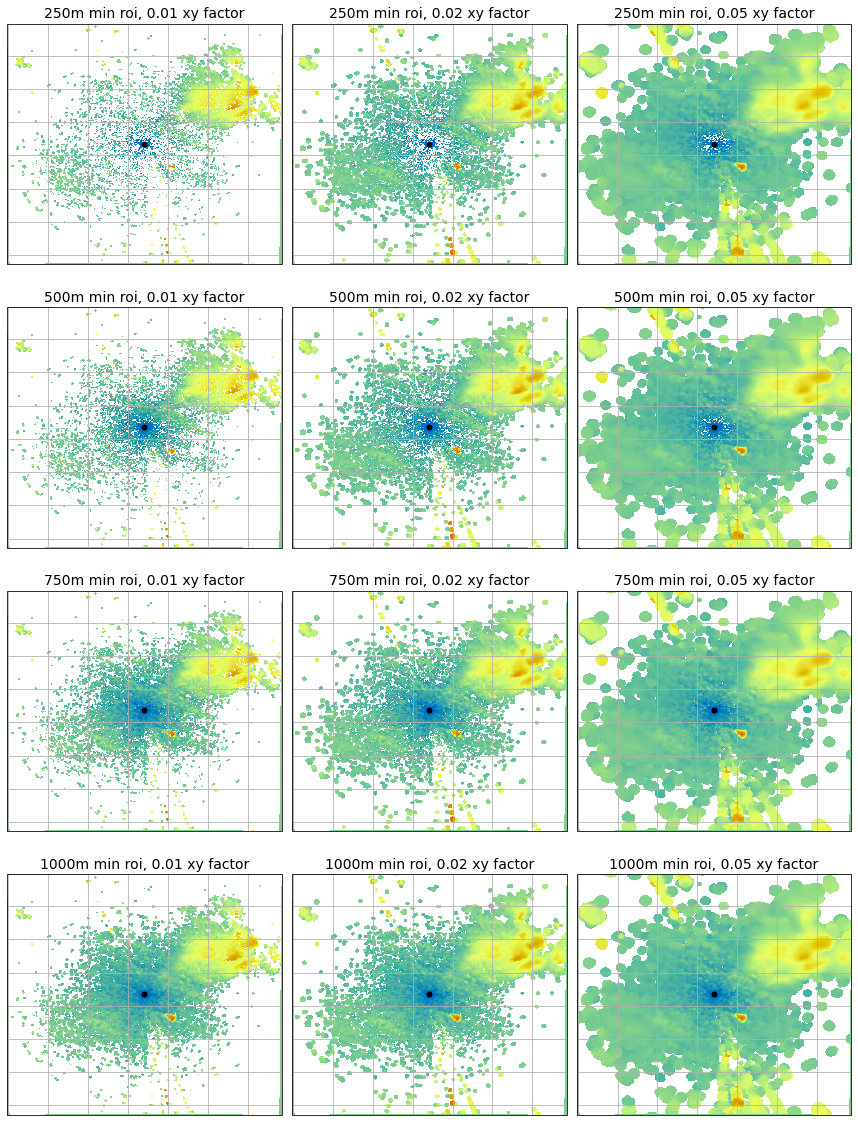

In [134]:
roi_fun = ['constant', 'dist', 'dist_beam']
weight_fun = ['Barnes', 'Barnes2', 'Cressman', 'Nearest']
min_radius = [250, 500, 750, 1000]
xy_factor = [0.01, 0.02, 0.05]
for radius in min_radius:
    for xy in xy_factor:
        xy_str = str(xy)
        xy_str = xy_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}min_{}xy_z1000.tif'.format(str(radius), xy_str))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 500, 500),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist', 
                                             z_factor=0.05, xy_factor=xy, min_radius=radius)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(min_radius), len(xy_factor), sharex=True, sharey=True, figsize=[12, 16], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, radius in enumerate(min_radius):
    row_pos = count
    for count2, xy in enumerate(xy_factor):
        col_pos = count2
        xy_str = str(xy)
        xy_str = xy_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}min_{}xy_z1000.tif'.format(str(radius), xy_str))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}m min roi, {} xy factor'.format(radius, xy)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

### z and xy factor

_Comments_: 500m min radius

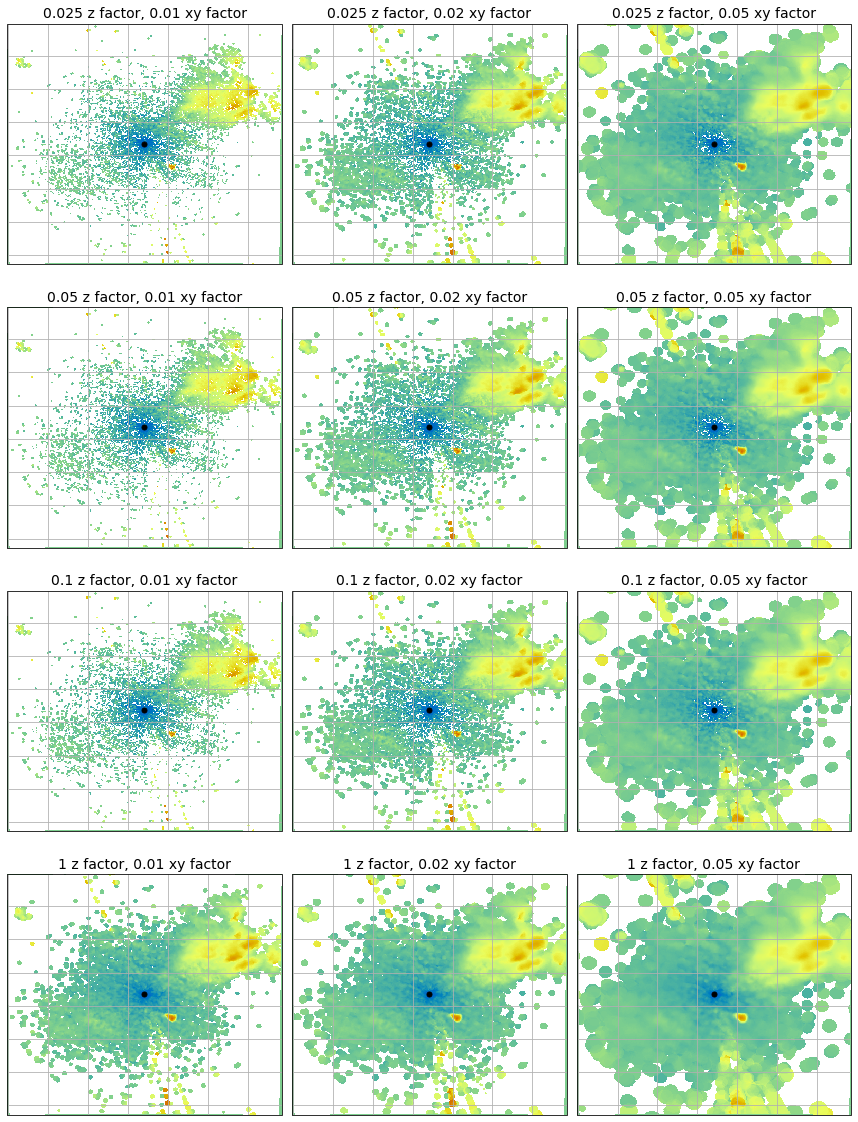

In [135]:
roi_fun = ['constant', 'dist', 'dist_beam']
weight_fun = ['Barnes', 'Barnes2', 'Cressman', 'Nearest']
min_radius = [500, 750, 1000]
xy_factor = [0.01, 0.02, 0.05]
z_factor = [0.025, 0.05, 0.1, 1]
for z in z_factor:
    z_str = str(z)
    z_str = z_str.replace('.','-')
    for xy in xy_factor:
        xy_str = str(xy)
        xy_str = xy_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}z{}xy.tif'.format(z_str, xy_str))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 500, 500),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist', 
                                             z_factor=z, xy_factor=xy, min_radius=500)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(z_factor), len(xy_factor), sharex=True, sharey=True, figsize=[12, 16], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, z in enumerate(z_factor):
    row_pos = count
    z_str = str(z)
    z_str = z_str.replace('.','-')
    for count2, xy in enumerate(xy_factor):
        col_pos = count2
        xy_str = str(xy)
        xy_str = xy_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}z{}xy.tif'.format(z_str, xy_str))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{} z factor, {} xy factor'.format(z, xy)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

## dist_beam roi function 

**h_factor**: height scaling (default = 1.0)  
**nb**: virtual beam width (default = 1.5)  
**bsp**: virtual beam spacing (default = 1.0)  
**min_radius**: minimum radius of influence (default = 500)  

### Min radius and virtual beam spacing

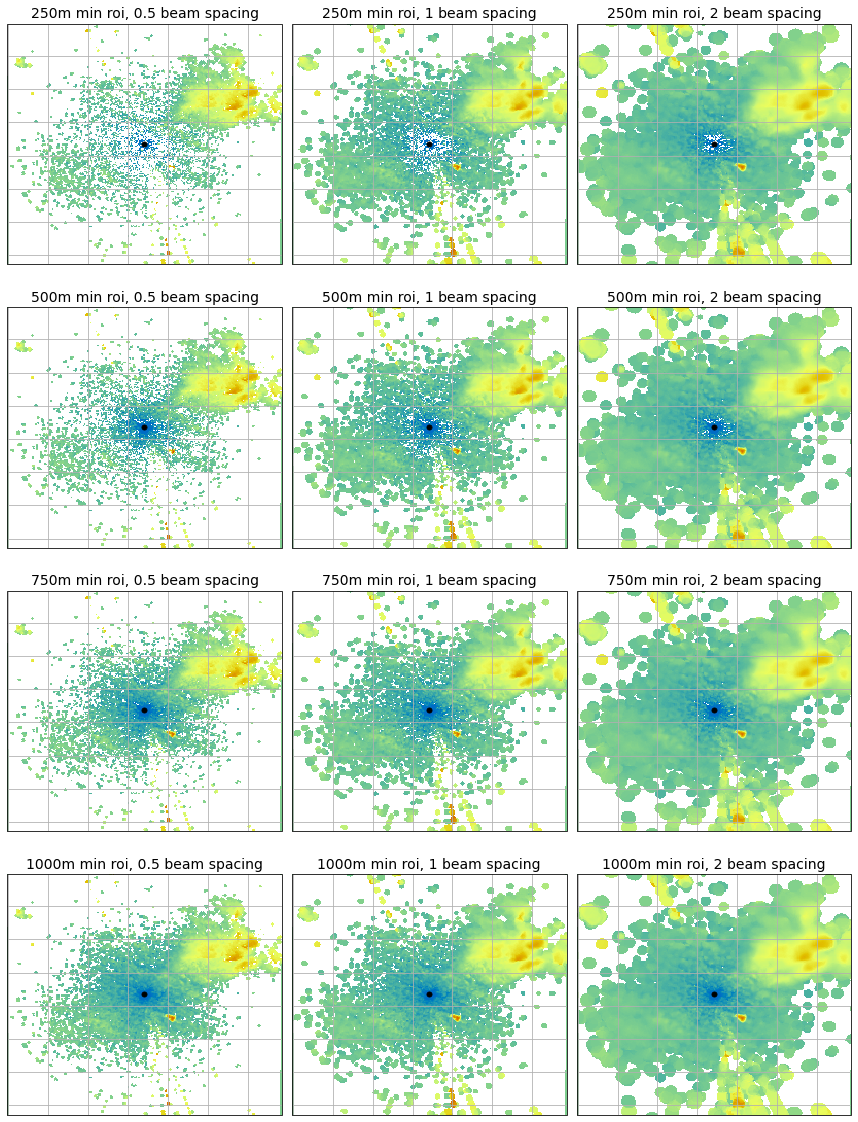

In [136]:
min_radius = [250, 500, 750, 1000]
h_factor = [0.5, 1, 2]
beam_width = [0.5, 1, 1.5, 3]
beam_spacing = [0.5, 1, 2]

for radius in min_radius:
    for bsp in beam_spacing:
        bsp_str = str(bsp)
        bsp_str = bsp_str.replace('.','-')

        file = os.path.join(outpath, 'out_{}radius_{}bsp.tif'.format(radius, bsp_str))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 250, 250),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist_beam', 
                                             min_radius=radius, h_factor=1.0, nb=1.5, bsp=bsp)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(min_radius), len(beam_spacing), sharex=True, sharey=True, figsize=[12, 16], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, radius in enumerate(min_radius):
    row_pos = count
    for count2, bsp in enumerate(beam_spacing):
        col_pos = count2
        bsp_str = str(bsp)
        bsp_str = bsp_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}radius_{}bsp.tif'.format(radius, bsp_str))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}m min roi, {} beam spacing'.format(radius, bsp)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

### Min radius and beam width

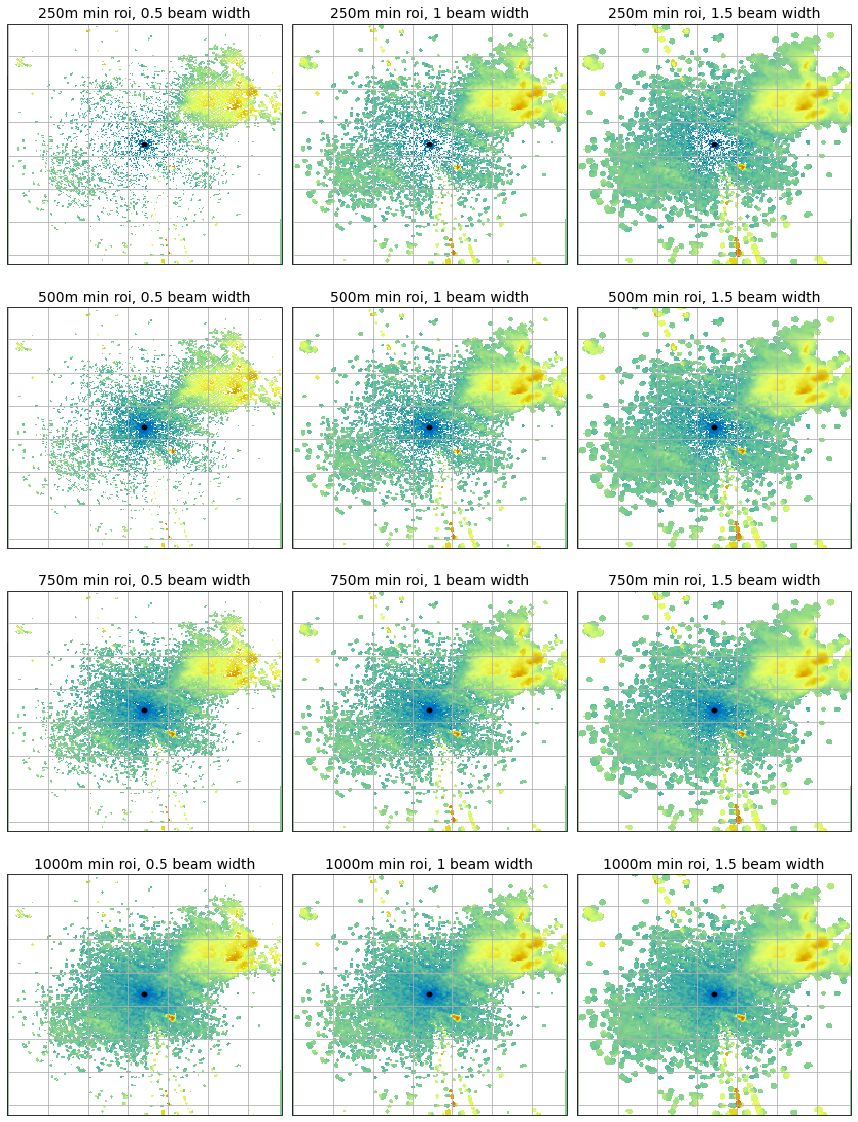

In [137]:
min_radius = [250, 500, 750, 1000]
h_factor = [0.5, 1, 2]
beam_width = [0.5, 1, 1.5]
beam_spacing = [0.5, 1, 2]

for radius in min_radius:
    for nb in beam_width:
        nb_str = str(nb)
        nb_str = nb_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}radius_{}nbv2.tif'.format(radius, nb_str))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 250, 250),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist_beam', 
                                             min_radius=radius, h_factor=1.0, nb=nb, bsp=1.0)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(min_radius), len(beam_width), sharex=True, sharey=True, figsize=[12, 16], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, radius in enumerate(min_radius):
    row_pos = count
    for count2, nb in enumerate(beam_width):
        col_pos = count2
        nb_str = str(nb)
        nb_str = nb_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}radius_{}nbv2.tif'.format(radius, nb_str))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}m min roi, {} beam width'.format(radius, nb)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

### Min radius and h factor

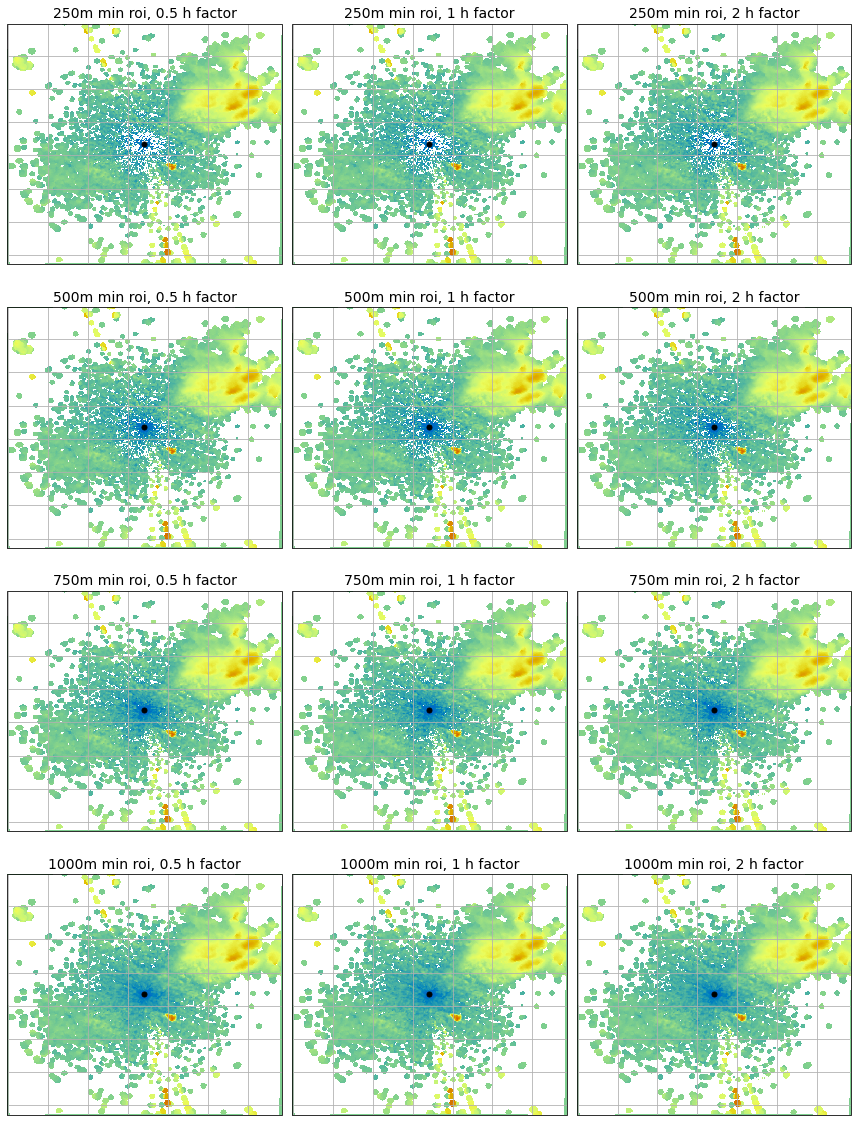

In [138]:
min_radius = [250, 500, 750, 1000]
h_factor = [0.5, 1, 2]
beam_width = [0.5, 1, 1.5]
beam_spacing = [0.5, 1, 2]

for radius in min_radius:
    for h in h_factor:
        h_str = str(h)
        h_str = h_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}radius_{}hv3.tif'.format(radius, h_str))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 500, 500),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist_beam', 
                                             min_radius=radius, h_factor=h, nb=1.5, bsp=1.0)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(min_radius), len(h_factor), sharex=True, sharey=True, figsize=[12, 16], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, radius in enumerate(min_radius):
    row_pos = count
    for count2, h in enumerate(h_factor):
        col_pos = count2
        h_str = str(h)
        h_str = h_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}radius_{}hv3.tif'.format(radius, h_str))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{}m min roi, {} h factor'.format(radius, h)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

### Beam spacing and beam width

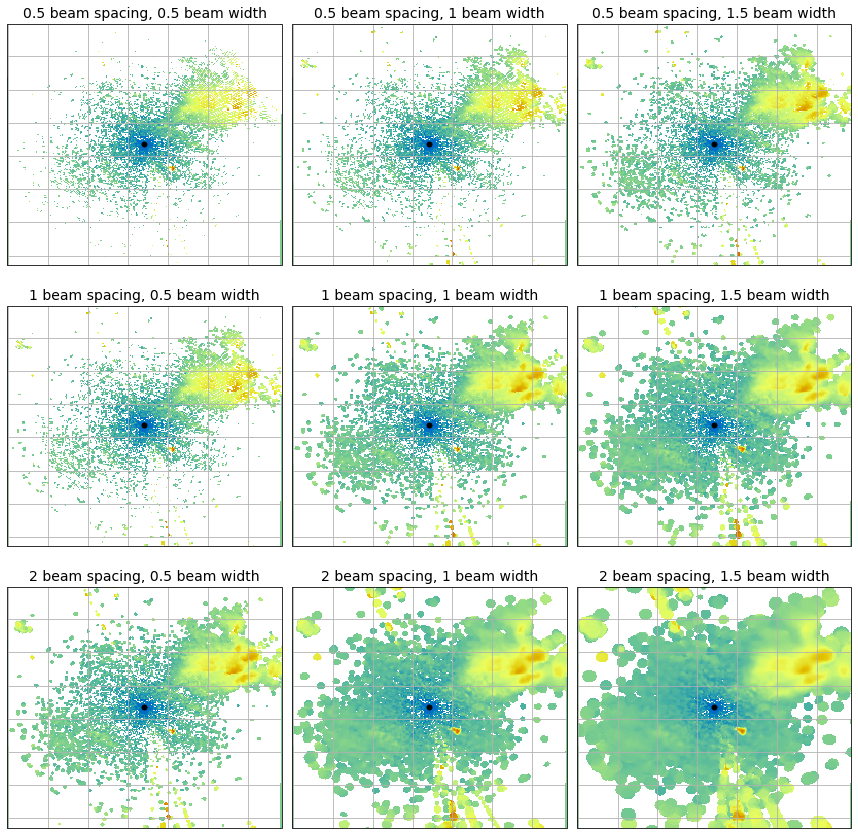

In [139]:
min_radius = [250, 500, 750, 1000]
h_factor = [0.5, 1, 2]
beam_width = [0.5, 1, 1.5]
beam_spacing = [0.5, 1, 2]

for bsp in beam_spacing:
    bsp_str = str(bsp)
    bsp_str = bsp_str.replace('.','-')
    for nb in beam_width:
        nb_str = str(nb)
        nb_str = nb_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}bsp_{}nb.tif'.format(bsp_str, nb_str))
        if not os.path.exists(file):
            grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 250, 250),
                                          grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                             gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist_beam', 
                                             min_radius=500, h_factor=1.0, nb=nb, bsp=bsp)
            gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
            
fig, axs = plt.subplots(len(beam_spacing), len(beam_width), sharex=True, sharey=True, figsize=[12, 12], subplot_kw={'projection': ccrs.PlateCarree()})
projection=ccrs.PlateCarree()
for count, bsp in enumerate(beam_spacing):
    row_pos = count
    bsp_str = str(bsp)
    bsp_str = bsp_str.replace('.','-')
    for count2, nb in enumerate(beam_width):
        col_pos = count2
        nb_str = str(nb)
        nb_str = nb_str.replace('.','-')
        file = os.path.join(outpath, 'out_{}bsp_{}nb.tif'.format(bsp_str, nb_str))
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        arr = band.ReadAsArray()
        gt = ds.GetGeoTransform()

        #ax = plt.subplot(4,3,(count+1+count2),projection=ccrs.PlateCarree())
        xmin = gt[0]
        xmax = gt[0] + ds.RasterXSize * gt[1]
        ymax = gt[3]
        ymin = gt[3] + ds.RasterYSize * gt[5]

        # transform bounds to map projection 
        lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
        upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
        img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
        ax = axs[row_pos, col_pos]
        # plot
        title = '{} beam spacing, {} beam width'.format(bsp, nb)
        ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
        ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
        ax.set_title(title, fontsize = 14)
        ax.set_extent(img_ext)
        gl = ax.gridlines(draw_labels=False, x_inline = False, y_inline = False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#plt.suptitle('Map to Grid', fontsize = 24)
plt.tight_layout(pad = 1)

## Some stuff that looks about right
**Grid shape**: 1x250x250  
**Grid limits**: (1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)  
**Gridding algorithm**: Map to grid  
**Weighting function**: Barnes  

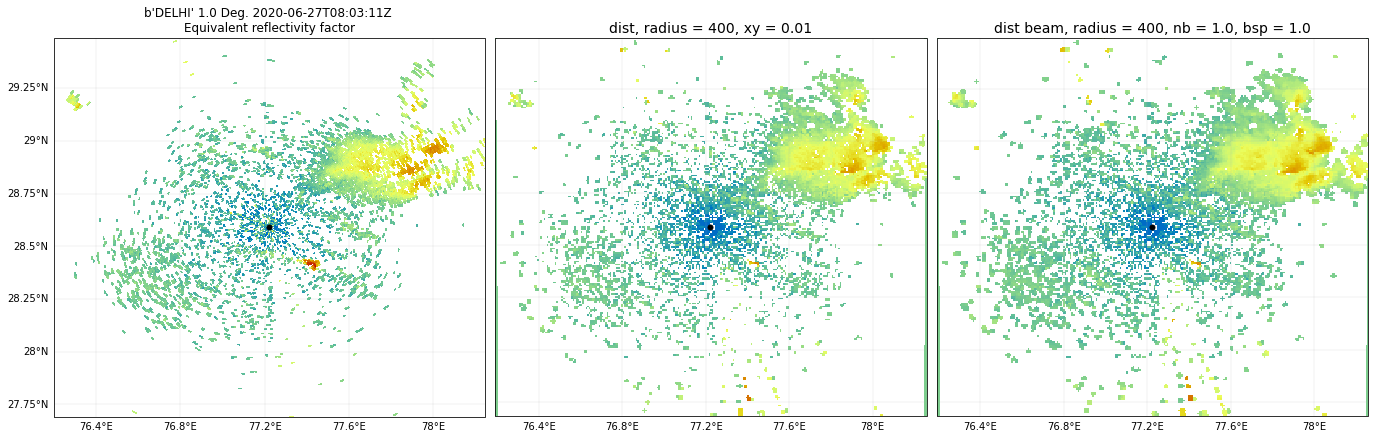

In [11]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

fig = plt.figure(figsize=[20, 8])

# set map projection
#projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],central_longitude=radar.longitude['data'][0])
projection=ccrs.PlateCarree()

## plot radar
display = pyart.graph.RadarMapDisplay(radar)
r = 100
min_lat  = radar.latitude['data'][0]  - (r / 6378 ) * (180 / np.pi)
max_lat  = radar.latitude['data'][0]  + (r / 6378 ) * (180 / np.pi)
min_lon = radar.longitude['data'][0] - (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)
max_lon = radar.longitude['data'][0] + (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)

ax = plt.subplot(1,3,1,projection=ccrs.PlateCarree())
display.plot_ppi_map('reflectivity',1,ax=ax, vmin=-20, vmax=60, 
                     colorbar_flag = False, cmap = 'pyart_HomeyerRainbow', embelish = False, alpha = 1.0,
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     projection=projection,fig=fig, lat_0=radar.latitude['data'][0], lon_0=radar.longitude['data'][0])
ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
#ax1.set_title('Radar PPI', fontsize = 16)
xspace = 0.4
yspace = 0.25
lon_lines=np.arange(np.floor(min_lon), np.ceil(max_lon)+xspace, xspace)
lat_lines=np.arange(np.floor(min_lat), np.ceil(max_lat)+yspace, yspace)
gl = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, alpha = 0.7, zorder = 0.5, linewidth = 0.25)
gl.xlocator = mticker.FixedLocator(lon_lines)
gl.ylocator = mticker.FixedLocator(lat_lines)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
#ax.set_extent(img_ext)


###
file = os.path.join(outpath, 'best_attempt_dist.tif')
if not os.path.exists(file):
    grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 250, 250),
                                  grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                     gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist', 
                                     z_factor=0.05, xy_factor=0.01, min_radius=400)
    gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')

        
ax = plt.subplot(1,3,2,projection=ccrs.PlateCarree())  
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
gt = ds.GetGeoTransform()

xmin = gt[0]
xmax = gt[0] + ds.RasterXSize * gt[1]
ymax = gt[3]
ymin = gt[3] + ds.RasterYSize * gt[5]

# transform bounds to map projection 
lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
# plot
title = 'dist, radius = 400, xy = 0.01'
ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, alpha = 0.7, zorder = 0.5, linewidth = 0.25)
ax.set_extent(img_ext)
ax.set_title(title, fontsize = 14)
gl.xlocator = mticker.FixedLocator(lon_lines)
gl.ylocator = mticker.FixedLocator(lat_lines)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False

###
file = os.path.join(outpath, 'best_attempt_distbeam.tif')

grid = pyart.map.grid_from_radars(radar, grid_shape=(1, 250, 250),
                                 grid_limits=((1000, 1000), (-100000.0, 100000.0), (-100000.0, 100000.0)),
                                 gridding_algo='map_to_grid',  weighting_function='Barnes', roi_func = 'dist_beam', 
                                 min_radius=400, h_factor=1.0, nb=1, bsp=0.75)
gtiff = pyart.io.write_grid_geotiff(grid, file, 'reflectivity', rgb=False, warp= True, cmap = 'pyart_HomeyerRainbow')
        
ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree())  
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
gt = ds.GetGeoTransform()

xmin = gt[0]
xmax = gt[0] + ds.RasterXSize * gt[1]
ymax = gt[3]
ymin = gt[3] + ds.RasterYSize * gt[5]

# transform bounds to map projection 
lower_left = projection.transform_point(xmin, ymin, ccrs.PlateCarree())
upper_right = projection.transform_point(xmax, ymax, ccrs.PlateCarree())
img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[1])
# plot
title = 'dist beam, radius = 400, nb = 1.0, bsp = 1.0'
ax.imshow(arr, origin='upper', extent = img_ext, vmin=-20, vmax=60,cmap = 'pyart_HomeyerRainbow', interpolation = 'nearest')
ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 5, c = 'black', transform = ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, alpha = 0.7, zorder = 0.5, linewidth = 0.25)
ax.set_extent(img_ext)
ax.set_title(title, fontsize = 14)
gl.xlocator = mticker.FixedLocator(lon_lines)
gl.ylocator = mticker.FixedLocator(lat_lines)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.left_labels = False
gl.right_labels = False
gl.top_labels = False

plt.tight_layout(pad = 1)